# Anomaly Detection

##  Dataset Preprocessing

In [ ]:
# Paths
RAW_ROOT = "/content/drive/MyDrive/ShanghaiTechDataset/shanghaitech"
FRAME_ROOT = os.path.join(RAW_ROOT, "testing/frames")
MASK_ROOT = os.path.join(RAW_ROOT, "testing/test_frame_mask")
OUTPUT_TEST = "/content/drive/MyDrive/shanghai_dataset/test"
ABN_OUT = os.path.join(OUTPUT_TEST, "abnormal")
NORM_OUT = os.path.join(OUTPUT_TEST, "normal")

os.makedirs(ABN_OUT, exist_ok=True)
os.makedirs(NORM_OUT, exist_ok=True)

MAX_FRAMES_PER_CLASS = 4000
NUM_THREADS = 8

print(" Collecting all frames with proper labels...")

# Collect all frames with their true labels
normal_frames = []
abnormal_frames = []

# Get all video IDs that have masks
mask_files = [f for f in os.listdir(MASK_ROOT) if f.endswith('.npy')]
print(f"Found {len(mask_files)} videos with masks")

for mask_file in tqdm(mask_files, desc="Processing videos"):
    vid_id = mask_file.replace('.npy', '')
    mask_path = os.path.join(MASK_ROOT, mask_file)
    frames_path = os.path.join(FRAME_ROOT, vid_id)

    if not os.path.exists(frames_path):
        print(f"Warning: No frames found for video {vid_id}")
        continue

    # Load video-level mask
    mask = np.load(mask_path)  # Shape: (num_frames,)
    frame_files = sorted(os.listdir(frames_path))

    # Process each frame
    for frame_idx, frame_file in enumerate(frame_files):
        if frame_idx >= len(mask):
            # Some videos might have more frames than mask entries
            break

        src_path = os.path.join(frames_path, frame_file)
        dst_name = f"{vid_id}_{frame_file}"

        # CORRECTED: Check if this specific frame is abnormal
        if mask[frame_idx] == 1:  # Abnormal frame
            abnormal_frames.append((src_path, dst_name))
        else:  # Normal frame
            normal_frames.append((src_path, dst_name))

print(f"\n Label distribution:")
print(f"Normal frames: {len(normal_frames)}")
print(f"Abnormal frames: {len(abnormal_frames)}")

# Sample balanced subsets
num_normal = min(MAX_FRAMES_PER_CLASS, len(normal_frames))
num_abnormal = min(MAX_FRAMES_PER_CLASS, len(abnormal_frames))

if len(normal_frames) > 0:
    normal_subset = random.sample(normal_frames, num_normal)
else:
    normal_subset = []

if len(abnormal_frames) > 0:
    abnormal_subset = random.sample(abnormal_frames, num_abnormal)
else:
    abnormal_subset = []

print(f"\n Sampling:")
print(f"Selected {len(normal_subset)} normal frames")
print(f"Selected {len(abnormal_subset)} abnormal frames")

# Copy function for parallel processing
def copy_frame(frame_info):
    src, dst_name, category = frame_info
    dst_dir = NORM_OUT if category == 'normal' else ABN_OUT
    dst_path = os.path.join(dst_dir, dst_name)
    try:
        shutil.copy(src, dst_path)
        return True
    except Exception as e:
        print(f"Error copying {src}: {e}")
        return False

# Prepare copy tasks
copy_tasks = []
for src, dst_name in normal_subset:
    copy_tasks.append((src, dst_name, 'normal'))
for src, dst_name in abnormal_subset:
    copy_tasks.append((src, dst_name, 'abnormal'))

# Parallel copy
print(f"\n⚡ Copying {len(copy_tasks)} frames in parallel...")
with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
    results = list(tqdm(executor.map(copy_frame, copy_tasks), total=len(copy_tasks)))

successful_copies = sum(results)
print(f"\n Successfully copied {successful_copies}/{len(copy_tasks)} frames")
print(f" Output directory: {OUTPUT_TEST}")

# Verify final counts
final_normal = len(os.listdir(NORM_OUT)) if os.path.exists(NORM_OUT) else 0
final_abnormal = len(os.listdir(ABN_OUT)) if os.path.exists(ABN_OUT) else 0
print(f"\n Final verification:")
print(f"Normal frames copied: {final_normal}")
print(f"Abnormal frames copied: {final_abnormal}")
print(f"Total: {final_normal + final_abnormal}")

# Sample a few frames to manually verify (optional)
print(f"\n Sample verification:")
if final_abnormal > 0:
    sample_abnormal = random.choice(os.listdir(ABN_OUT))
    print(f"Sample abnormal frame: {sample_abnormal}")
if final_normal > 0:
    sample_normal = random.choice(os.listdir(NORM_OUT))
    print(f"Sample normal frame: {sample_normal}")

Found 107 videos with masks


Processing videos: 100%|██████████| 107/107 [00:00<00:00, 137.54it/s]



 Label distribution:
Normal frames: 23465
Abnormal frames: 17326

 Sampling:
Selected 4000 normal frames
Selected 4000 abnormal frames

⚡ Copying 8000 frames in parallel...


100%|██████████| 8000/8000 [03:19<00:00, 40.14it/s]



 Successfully copied 8000/8000 frames
 Output directory: /content/drive/MyDrive/shanghai_dataset/test

 Final verification:
Normal frames copied: 4000
Abnormal frames copied: 4000
Total: 8000

 Sample verification:
Sample abnormal frame: 05_0020_442.jpg
Sample normal frame: 01_0030_056.jpg


In [ ]:


VIDEO_FOLDER = "/content/drive/MyDrive/ShanghaiTechDataset/shanghaitech/training/videos"
OUTPUT_FOLDER = "/content/drive/MyDrive/ShanghaiTechDataset/shanghaitech/training/frames"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

video_files = sorted([f for f in os.listdir(VIDEO_FOLDER) if f.endswith(".avi")])

frame_count = 0
for video_name in tqdm(video_files, desc="🎥 Extracting frames"):
    video_path = os.path.join(VIDEO_FOLDER, video_name)
    cap = cv2.VideoCapture(video_path)

    vid = os.path.splitext(video_name)[0]  # e.g., "01_0011"
    idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_filename = f"{vid}_frame_{idx:04d}.jpg"
        out_path = os.path.join(OUTPUT_FOLDER, frame_filename)
        cv2.imwrite(out_path, frame)
        idx += 1
        frame_count += 1

    cap.release()

print(f"\nDone! Extracted {frame_count} frames from {len(video_files)} videos.")
print(f"Frames saved to: {OUTPUT_FOLDER}")


🎥 Extracting frames: 100%|██████████| 330/330 [44:25<00:00,  8.08s/it]


Done! Extracted 274515 frames from 330 videos.
Frames saved to: /content/drive/MyDrive/ShanghaiTechDataset/shanghaitech/training/frames


## Set device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/drive/',
            force_remount = True,
            timeout_ms = 500000)

Mounted at /content/drive/


# CLIP

## Install dependencies

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-og_abv00
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-og_abv00
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import clip
import torch
import seaborn as sns
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, classification_report
from sklearn.cluster import KMeans
import random
import torch.nn.functional as F
from itertools import product
import warnings

## Dataset Loading

In [ ]:
def load_dataset(normal_dir, abnormal_dir, max_per_class=2000, balance=True):
    """
    Load and prepare the dataset for anomaly detection.

    Args:
        normal_dir (str): Path to normal images directory
        abnormal_dir (str): Path to abnormal images directory
        max_per_class (int): Maximum number of images per class
        balance (bool): Whether to balance the dataset

    Returns:
        tuple: (all_data, normal_data, abnormal_data)
    """
    print("Loading dataset...")

    def load_image_paths(folder, label):
        """Load image paths from a folder with given label"""
        if not os.path.exists(folder):
            print(f"Warning: Directory does not exist: {folder}")
            return []

        image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if max_per_class:
            image_files = image_files[:max_per_class]

        return [(os.path.join(folder, f), label) for f in image_files]

    # Load image paths
    normal_data = load_image_paths(normal_dir, 0)  # 0 = normal
    abnormal_data = load_image_paths(abnormal_dir, 1)  # 1 = abnormal

    print(f"Loaded {len(normal_data)} normal images from {normal_dir}")
    print(f"Loaded {len(abnormal_data)} abnormal images from {abnormal_dir}")

    # Balance dataset if requested
    if balance:
        min_size = min(len(normal_data), len(abnormal_data))
        normal_data = normal_data[:min_size]
        abnormal_data = abnormal_data[:min_size]
        print(f"Balanced dataset: {len(normal_data)} normal + {len(abnormal_data)} abnormal")

    # Combine and shuffle
    all_data = normal_data + abnormal_data
    random.shuffle(all_data)

    return all_data, normal_data, abnormal_data

def create_train_test_split(all_data, test_ratio=0.3):
    """
    Split data into train and test sets.

    Args:
        all_data (list): List of (image_path, label) tuples
        test_ratio (float): Ratio of data for testing

    Returns:
        tuple: (train_data, test_data)
    """
    # Separate by class for stratified split
    normal_data = [item for item in all_data if item[1] == 0]
    abnormal_data = [item for item in all_data if item[1] == 1]

    # Split each class
    normal_test_size = int(len(normal_data) * test_ratio)
    abnormal_test_size = int(len(abnormal_data) * test_ratio)

    normal_test = normal_data[:normal_test_size]
    normal_train = normal_data[normal_test_size:]

    abnormal_test = abnormal_data[:abnormal_test_size]
    abnormal_train = abnormal_data[abnormal_test_size:]

    train_data = normal_train + abnormal_train
    test_data = normal_test + abnormal_test

    random.shuffle(train_data)
    random.shuffle(test_data)

    print(f"Train set: {len(normal_train)} normal + {len(abnormal_train)} abnormal = {len(train_data)} total")
    print(f"Test set: {len(normal_test)} normal + {len(abnormal_test)} abnormal = {len(test_data)} total")

    return train_data, test_data


## Model initialization

In [ ]:
class CLIPAnomalyDetector:
    """CLIP-based anomaly detection system"""

    def __init__(self, model_name="ViT-B/32"):
        """
        Initialize CLIP model for anomaly detection.

        Args:
            model_name (str): CLIP model architecture to use
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        # Load CLIP model
        try:
            self.model, self.preprocess = clip.load(model_name, device=self.device)
            print(f"Successfully loaded CLIP model: {model_name}")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        # Model components
        self.normal_prototypes = None
        self.abnormal_prototypes = None
        self.ensemble_weights = None
        self.optimal_threshold = None

    def extract_image_features(self, image_paths, batch_size=16, max_samples=None):
        """
        Extract CLIP features from a list of image paths.

        Args:
            image_paths (list): List of image file paths
            batch_size (int): Batch size for processing
            max_samples (int): Maximum number of samples to process

        Returns:
            torch.Tensor: Normalized image features
        """
        if max_samples:
            image_paths = random.sample(image_paths, min(max_samples, len(image_paths)))

        features = []

        print(f"Extracting features from {len(image_paths)} images...")

        for i in tqdm(range(0, len(image_paths), batch_size)):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []

            # Load and preprocess images
            for img_path in batch_paths:
                try:
                    image = Image.open(img_path).convert("RGB")
                    image_tensor = self.preprocess(image).unsqueeze(0)
                    batch_images.append(image_tensor)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue

            if not batch_images:
                continue

            # Process batch
            try:
                batch_tensor = torch.cat(batch_images).to(self.device)

                with torch.no_grad():
                    batch_features = self.model.encode_image(batch_tensor).float()
                    batch_features = F.normalize(batch_features, dim=-1)
                    features.append(batch_features.cpu())

                del batch_tensor
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error processing batch: {e}")
                continue

        if features:
            all_features = torch.cat(features, dim=0)
            print(f"Extracted features shape: {all_features.shape}")
            return all_features
        else:
            print("No features extracted!")
            return None


## Prototype Creation

In [ ]:
def create_visual_prototypes(detector, normal_data, abnormal_data,
                           num_prototypes=50, use_clustering=True, max_samples=200):
    """
    Create visual prototypes for normal and abnormal classes.

    Args:
        detector (CLIPAnomalyDetector): Initialized detector
        normal_data (list): List of (path, label) for normal images
        abnormal_data (list): List of (path, label) for abnormal images
        num_prototypes (int): Number of prototypes per class
        use_clustering (bool): Whether to use clustering for prototype selection
        max_samples (int): Maximum samples for prototype creation

    Returns:
        tuple: (normal_prototypes, abnormal_prototypes)
    """
    print("Creating visual prototypes...")

    # Extract features from training data
    normal_paths = [item[0] for item in normal_data]
    abnormal_paths = [item[0] for item in abnormal_data]

    normal_features = detector.extract_image_features(normal_paths, max_samples=max_samples)
    abnormal_features = detector.extract_image_features(abnormal_paths, max_samples=max_samples)

    if normal_features is None or abnormal_features is None:
        print("Failed to extract features for prototype creation")
        return None, None

    def select_prototypes(features, n_prototypes, use_clustering=True):
        """Select prototypes from features"""
        if len(features) <= n_prototypes:
            return features

        if use_clustering:
            print(f"Using K-means clustering to select {n_prototypes} prototypes...")

            # Perform K-means clustering
            kmeans = KMeans(n_clusters=n_prototypes, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(features.numpy())

            # Select point closest to each centroid
            prototypes = []
            for i in range(n_prototypes):
                cluster_points = features[cluster_labels == i]
                if len(cluster_points) > 0:
                    # Find point closest to cluster center
                    centroid = torch.tensor(kmeans.cluster_centers_[i])
                    distances = torch.norm(cluster_points - centroid, dim=1)
                    closest_idx = distances.argmin()
                    prototypes.append(cluster_points[closest_idx])

            return torch.stack(prototypes) if prototypes else features[:n_prototypes]
        else:
            # Random selection
            indices = torch.randperm(len(features))[:n_prototypes]
            return features[indices]

    # Create prototypes
    normal_prototypes = select_prototypes(normal_features, num_prototypes, use_clustering)
    abnormal_prototypes = select_prototypes(abnormal_features, num_prototypes, use_clustering)

    print(f"Created {len(normal_prototypes)} normal prototypes")
    print(f"Created {len(abnormal_prototypes)} abnormal prototypes")

    # Store in detector
    detector.normal_prototypes = normal_prototypes
    detector.abnormal_prototypes = abnormal_prototypes

    return normal_prototypes, abnormal_prototypes


## Inference

In [ ]:
def compute_anomaly_scores(detector, test_data, batch_size=16):
    """
    Compute anomaly scores for test data using multiple similarity methods.

    Args:
        detector (CLIPAnomalyDetector): Detector with trained prototypes
        test_data (list): List of (image_path, label) tuples
        batch_size (int): Batch size for processing

    Returns:
        dict: Dictionary containing scores for different methods
    """
    if detector.normal_prototypes is None or detector.abnormal_prototypes is None:
        raise ValueError("Prototypes not created. Run create_visual_prototypes first.")

    print("Computing anomaly scores...")

    # Initialize score storage
    all_scores = {
        'max_similarity': [],
        'mean_similarity': [],
        'topk_similarity': [],
        'distance_based': []
    }
    labels = []

    normal_prototypes = detector.normal_prototypes.to(detector.device)
    abnormal_prototypes = detector.abnormal_prototypes.to(detector.device)

    # Process in batches
    for i in tqdm(range(0, len(test_data), batch_size)):
        batch = test_data[i:i+batch_size]
        batch_images = []
        batch_labels = []

        # Load batch images
        for img_path, label in batch:
            try:
                image = Image.open(img_path).convert("RGB")
                image_tensor = detector.preprocess(image).unsqueeze(0)
                batch_images.append(image_tensor)
                batch_labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

        if not batch_images:
            continue

        try:
            batch_tensor = torch.cat(batch_images).to(detector.device)

            with torch.no_grad():
                # Extract image features
                image_features = detector.model.encode_image(batch_tensor).float()
                image_features = F.normalize(image_features, dim=-1)

                # Method 1: Max similarity
                normal_sim_max = torch.mm(image_features, normal_prototypes.T).max(dim=1)[0]
                abnormal_sim_max = torch.mm(image_features, abnormal_prototypes.T).max(dim=1)[0]
                scores_max = (abnormal_sim_max - normal_sim_max).cpu().numpy()

                # Method 2: Mean similarity
                normal_sim_mean = torch.mm(image_features, normal_prototypes.T).mean(dim=1)
                abnormal_sim_mean = torch.mm(image_features, abnormal_prototypes.T).mean(dim=1)
                scores_mean = (abnormal_sim_mean - normal_sim_mean).cpu().numpy()

                # Method 3: Top-k similarity (top 5)
                k = min(5, normal_prototypes.shape[0])
                normal_sim_topk = torch.mm(image_features, normal_prototypes.T).topk(k, dim=1)[0].mean(dim=1)
                abnormal_sim_topk = torch.mm(image_features, abnormal_prototypes.T).topk(k, dim=1)[0].mean(dim=1)
                scores_topk = (abnormal_sim_topk - normal_sim_topk).cpu().numpy()

                # Method 4: Distance-based
                normal_distances = torch.cdist(image_features.unsqueeze(0), normal_prototypes.unsqueeze(0)).squeeze()
                abnormal_distances = torch.cdist(image_features.unsqueeze(0), abnormal_prototypes.unsqueeze(0)).squeeze()

                if normal_distances.dim() == 1:
                    normal_distances = normal_distances.unsqueeze(0)
                    abnormal_distances = abnormal_distances.unsqueeze(0)

                normal_dist_min = normal_distances.min(dim=1)[0]
                abnormal_dist_min = abnormal_distances.min(dim=1)[0]
                scores_dist = (normal_dist_min - abnormal_dist_min).cpu().numpy()

                # Store scores
                all_scores['max_similarity'].extend(scores_max)
                all_scores['mean_similarity'].extend(scores_mean)
                all_scores['topk_similarity'].extend(scores_topk)
                all_scores['distance_based'].extend(scores_dist)
                labels.extend(batch_labels)

            del batch_tensor, image_features
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error processing batch: {e}")
            continue

    # Convert to numpy arrays
    for method in all_scores:
        all_scores[method] = np.array(all_scores[method])
    labels = np.array(labels)

    print(f"Computed scores for {len(labels)} samples")
    return all_scores, labels

def optimize_ensemble_weights(all_scores, labels):
    """
    Find optimal ensemble weights for combining different scoring methods.

    Args:
        all_scores (dict): Dictionary of scoring methods and their scores
        labels (np.array): True labels

    Returns:
        tuple: (best_weights, best_ensemble_scores, best_auc)
    """
    print("Optimizing ensemble weights...")

    methods = list(all_scores.keys())
    scores_matrix = np.array([all_scores[method] for method in methods]).T

    best_auc = 0
    best_weights = None
    best_scores = None

    # Test different weight combinations
    weight_options = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    total_combinations = len(weight_options) ** len(methods)

    print(f"Testing {total_combinations} weight combinations...")

    for weights in product(weight_options, repeat=len(methods)):
        if sum(weights) == 0:
            continue

        # Normalize weights
        weights = np.array(weights) / sum(weights)

        # Compute weighted ensemble
        ensemble_scores = np.dot(scores_matrix, weights)

        try:
            auc = roc_auc_score(labels, ensemble_scores)
            if auc > best_auc:
                best_auc = auc
                best_weights = weights
                best_scores = ensemble_scores
        except:
            continue

    # Store optimal weights in detector
    optimal_weights = dict(zip(methods, best_weights))

    print(f"Best ensemble AUC: {best_auc:.4f}")
    print("Optimal weights:")
    for method, weight in optimal_weights.items():
        print(f"  {method}: {weight:.3f}")

    return best_weights, best_scores, best_auc, optimal_weights

def predict_anomalies(detector, image_paths, threshold=None):
    """
    Predict anomalies for new images.

    Args:
        detector (CLIPAnomalyDetector): Trained detector
        image_paths (list): List of image paths to predict
        threshold (float): Decision threshold (if None, uses stored optimal threshold)

    Returns:
        tuple: (predictions, scores)
    """
    if threshold is None:
        threshold = detector.optimal_threshold
        if threshold is None:
            print("No threshold set. Using 0.0 as default.")
            threshold = 0.0

    # Create test data format
    test_data = [(path, 0) for path in image_paths]  # Labels don't matter for prediction

    # Compute scores
    all_scores, _ = compute_anomaly_scores(detector, test_data)

    # Apply ensemble weights if available
    if detector.ensemble_weights is not None:
        methods = list(all_scores.keys())
        scores_matrix = np.array([all_scores[method] for method in methods]).T
        final_scores = np.dot(scores_matrix, detector.ensemble_weights)
    else:
        # Use max similarity as default
        final_scores = all_scores['max_similarity']

    # Make predictions
    predictions = (final_scores > threshold).astype(int)

    return predictions, final_scores


## Evaluation cell

In [ ]:
def evaluate_performance(scores, labels, method_name="Ensemble"):
    """
    Comprehensive performance evaluation.

    Args:
        scores (np.array): Anomaly scores
        labels (np.array): True labels
        method_name (str): Name of the method being evaluated

    Returns:
        dict: Dictionary containing all performance metrics
    """
    print(f"Evaluating {method_name} performance...")

    # Calculate AUC
    auc = roc_auc_score(labels, scores)

    # Find optimal threshold using F1-score
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else np.median(scores)

    # Make predictions with optimal threshold
    predictions = (scores > optimal_threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)

    # Detailed classification report
    report = classification_report(labels, predictions,
                                 target_names=['Normal', 'Abnormal'],
                                 output_dict=True, zero_division=0)

    # Print results
    print(f"\n{method_name} Performance Results:")
    print("-" * 40)
    print(f"AUC Score: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"\nNormal Class:")
    print(f"  Precision: {report['Normal']['precision']:.4f}")
    print(f"  Recall: {report['Normal']['recall']:.4f}")
    print(f"  F1-Score: {report['Normal']['f1-score']:.4f}")
    print(f"\nAbnormal Class:")
    print(f"  Precision: {report['Abnormal']['precision']:.4f}")
    print(f"  Recall: {report['Abnormal']['recall']:.4f}")
    print(f"  F1-Score: {report['Abnormal']['f1-score']:.4f}")

    # Performance interpretation
    if auc >= 0.9:
        performance_level = "Outstanding"
    elif auc >= 0.8:
        performance_level = "Excellent"
    elif auc >= 0.7:
        performance_level = "Good"
    elif auc >= 0.6:
        performance_level = "Fair"
    else:
        performance_level = "Poor"

    print(f"\nPerformance Level: {performance_level}")

    return {
        'auc': auc,
        'accuracy': accuracy,
        'optimal_threshold': optimal_threshold,
        'predictions': predictions,
        'classification_report': report,
        'performance_level': performance_level
    }

def compare_methods(all_scores, labels):
    """
    Compare performance of different scoring methods.

    Args:
        all_scores (dict): Dictionary of different scoring methods
        labels (np.array): True labels

    Returns:
        dict: Comparison results
    """
    print("Comparing different scoring methods...")
    print("=" * 50)

    results = {}

    for method_name, scores in all_scores.items():
        if len(scores) > 0 and len(np.unique(labels)) > 1:
            auc = roc_auc_score(labels, scores)
            results[method_name] = auc
            print(f"{method_name.replace('_', ' ').title()}: AUC = {auc:.4f}")

    # Sort by performance
    sorted_methods = sorted(results.items(), key=lambda x: x[1], reverse=True)

    print(f"\nBest individual method: {sorted_methods[0][0]} (AUC: {sorted_methods[0][1]:.4f})")

    return results, sorted_methods

## Pipeline cell

In [ ]:
def run_complete_pipeline(normal_dir, abnormal_dir, test_size=1000, num_prototypes=50):
    """
    Run the complete CLIP anomaly detection pipeline.

    Args:
        normal_dir (str): Path to normal images
        abnormal_dir (str): Path to abnormal images
        test_size (int): Number of test samples
        num_prototypes (int): Number of prototypes per class

    Returns:
        tuple: (detector, final_results)
    """
    print("Starting Complete CLIP Anomaly Detection Pipeline")
    print("=" * 60)

    # Step 1: Load data
    all_data, normal_data, abnormal_data = load_dataset(normal_dir, abnormal_dir)

    if len(all_data) == 0:
        print("Error: No data loaded!")
        return None, None

    # Step 2: Create train-test split
    train_data, test_data = create_train_test_split(all_data, test_ratio=0.3)

    # Limit test size if specified
    if test_size and len(test_data) > test_size:
        test_data = test_data[:test_size]
        print(f"Limited test set to {test_size} samples")

    # Step 3: Initialize detector
    detector = CLIPAnomalyDetector("ViT-B/32")

    # Step 4: Create prototypes using training data
    train_normal = [item for item in train_data if item[1] == 0]
    train_abnormal = [item for item in train_data if item[1] == 1]

    normal_prototypes, abnormal_prototypes = create_visual_prototypes(
        detector, train_normal, train_abnormal,
        num_prototypes=num_prototypes, use_clustering=True
    )

    if normal_prototypes is None:
        print("Error: Failed to create prototypes!")
        return None, None

    # Step 5: Compute anomaly scores on test data
    all_scores, test_labels = compute_anomaly_scores(detector, test_data)

    # Step 6: Compare individual methods
    method_results, sorted_methods = compare_methods(all_scores, test_labels)

    # Step 7: Optimize ensemble
    best_weights, best_ensemble_scores, best_auc, optimal_weights = optimize_ensemble_weights(all_scores, test_labels)

    # Store optimal configuration in detector
    detector.ensemble_weights = best_weights

    # Step 8: Final evaluation
    final_results = evaluate_performance(best_ensemble_scores, test_labels, "Final Ensemble")

    # Store optimal threshold
    detector.optimal_threshold = final_results['optimal_threshold']

    print("\n" + "=" * 60)
    print("PIPELINE COMPLETE")
    print("=" * 60)
    print(f"Final AUC: {final_results['auc']:.4f}")
    print(f"Final Accuracy: {final_results['accuracy']:.4f}")
    print(f"Performance Level: {final_results['performance_level']}")

    return test_data, all_scores, test_labels, best_weights, best_ensemble_scores, final_results


## Usage

In [ ]:
normal_dir = "/content/drive/MyDrive/shanghai_dataset/test/normal"
abnormal_dir = "/content/drive/MyDrive/shanghai_dataset/test/abnormal"
test_data, all_scores, test_labels, best_weights, best_ensemble_scores, final_results = run_complete_pipeline(normal_dir, abnormal_dir,test_size=2000,
        num_prototypes=100)

# Save CLIP method scores
np.save("clip_max_similarity.npy", all_scores['max_similarity'])
np.save("clip_mean_similarity.npy", all_scores['mean_similarity'])
np.save("clip_topk_similarity.npy", all_scores['topk_similarity'])
np.save("clip_distance_based.npy", all_scores['distance_based'])

# Save fused ensemble score
np.save("clip_fused_score.npy", best_ensemble_scores)

np.save("clip_test_labels.npy", test_labels)
# Save the best weights if you want to reuse them exactly
np.save("clip_best_weights.npy", best_weights)

Starting Complete CLIP Anomaly Detection Pipeline
Loading dataset...
Loaded 2000 normal images from /content/drive/MyDrive/shanghai_dataset/test/normal
Loaded 2000 abnormal images from /content/drive/MyDrive/shanghai_dataset/test/abnormal
Balanced dataset: 2000 normal + 2000 abnormal
Train set: 1400 normal + 1400 abnormal = 2800 total
Test set: 600 normal + 600 abnormal = 1200 total
Using device: cuda
Successfully loaded CLIP model: ViT-B/32
Creating visual prototypes...
Extracting features from 200 images...


100%|██████████| 13/13 [00:02<00:00,  5.24it/s]


Extracted features shape: torch.Size([200, 512])
Extracting features from 200 images...


100%|██████████| 13/13 [00:02<00:00,  5.19it/s]


Extracted features shape: torch.Size([200, 512])
Using K-means clustering to select 100 prototypes...
Using K-means clustering to select 100 prototypes...
Created 100 normal prototypes
Created 100 abnormal prototypes
Computing anomaly scores...


100%|██████████| 75/75 [00:14<00:00,  5.09it/s]


Computed scores for 1200 samples
Comparing different scoring methods...
Max Similarity: AUC = 0.7694
Mean Similarity: AUC = 0.6415
Topk Similarity: AUC = 0.7401
Distance Based: AUC = 0.7720

Best individual method: distance_based (AUC: 0.7720)
Optimizing ensemble weights...
Testing 1296 weight combinations...
Best ensemble AUC: 0.7830
Optimal weights:
  max_similarity: 0.000
  mean_similarity: 0.222
  topk_similarity: 0.444
  distance_based: 0.333
Evaluating Final Ensemble performance...

Final Ensemble Performance Results:
----------------------------------------
AUC Score: 0.7830
Accuracy: 0.6975
Optimal Threshold: -0.0192

Normal Class:
  Precision: 0.8160
  Recall: 0.5100
  F1-Score: 0.6277

Abnormal Class:
  Precision: 0.6436
  Recall: 0.8850
  F1-Score: 0.7453

Performance Level: Good

PIPELINE COMPLETE
Final AUC: 0.7830
Final Accuracy: 0.6975
Performance Level: Good


## Visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc as sk_auc,
    precision_recall_curve, confusion_matrix
)
from PIL import Image

plt.style.use('default')
sns.set_palette("husl")

# 1. ROC Curve
def plot_roc_curve(best_ensemble_scores, test_labels, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(test_labels, best_ensemble_scores)
    roc_auc = sk_auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2. Precision-Recall Curve
def plot_precision_recall_curve(scores, labels, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(labels, scores)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='purple', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Score Distributions per Method
def plot_score_distributions(all_scores, test_labels, title="Score Distributions"):
    plt.figure(figsize=(8, 5))
    for method, scores in all_scores.items():
        sns.kdeplot(scores[test_labels == 0], label=f"{method} Normal", linestyle='--')
        sns.kdeplot(scores[test_labels == 1], label=f"{method} Abnormal")
    plt.title(title)
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. Prototype Gallery
def show_prototype_gallery(best_ensemble_scores, test_image_paths, num=12, title="Top Abnormal Predictions"):
    top_indices = np.argsort(best_ensemble_scores)[-num:][::-1]
    ncols = 4
    nrows = int(np.ceil(num / ncols))
    plt.figure(figsize=(ncols * 3, nrows * 3))

    for i, idx in enumerate(top_indices):
        img = Image.open(test_image_paths[idx])
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img)
        plt.title(f"Score: {best_ensemble_scores[idx]:.3f}")
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 5. AUC vs Weight Bar Chart
def plot_auc_weight_bar_chart(all_scores, test_labels, best_weights, title="Model AUC vs Ensemble Weight"):
    aucs = []
    for method, scores in all_scores.items():
        fpr, tpr, _ = roc_curve(test_labels, scores)
        aucs.append(sk_auc(fpr, tpr))

    methods = list(all_scores.keys())
    x = np.arange(len(methods))

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.bar(x - 0.2, aucs, width=0.4, label='AUC', color='skyblue')
    ax1.set_ylabel("AUC", color='blue')
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.bar(x + 0.2, best_weights, width=0.4, label='Weight', color='orange')
    ax2.set_ylabel("Weight", color='orange')
    ax2.set_ylim(0, 1)

    plt.xticks(x, methods, rotation=45)
    plt.title(title)
    fig.tight_layout()
    plt.show()

# 6. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Abnormal'],
                yticklabels=['Normal', 'Abnormal'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()


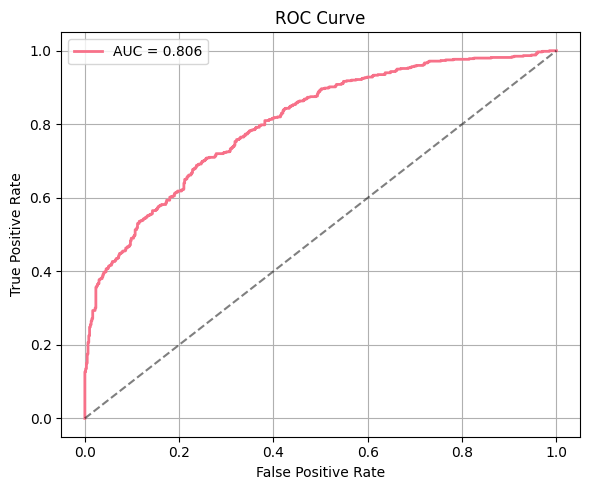

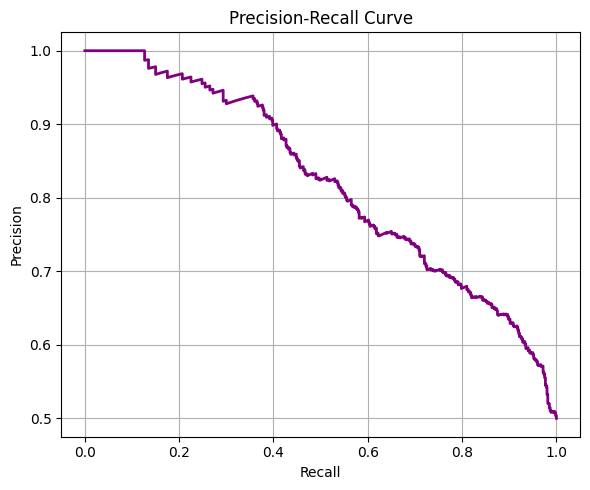

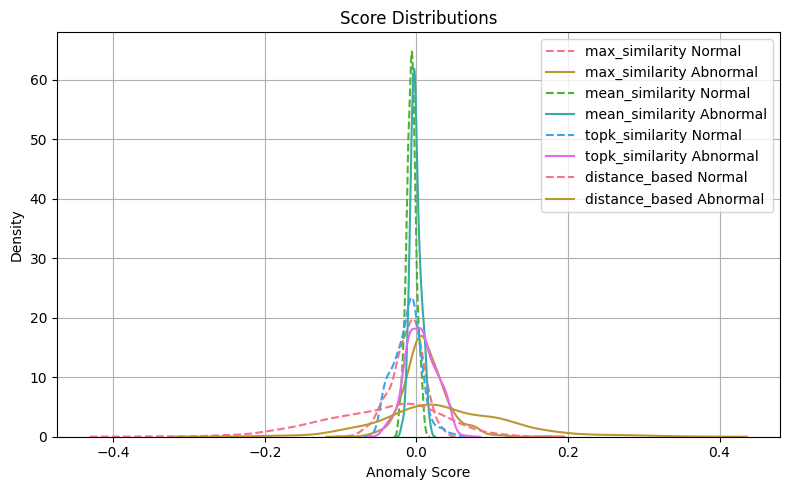

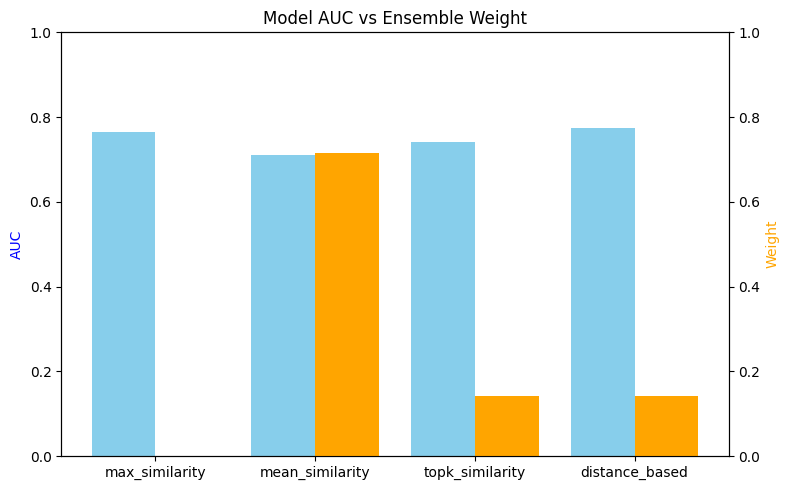

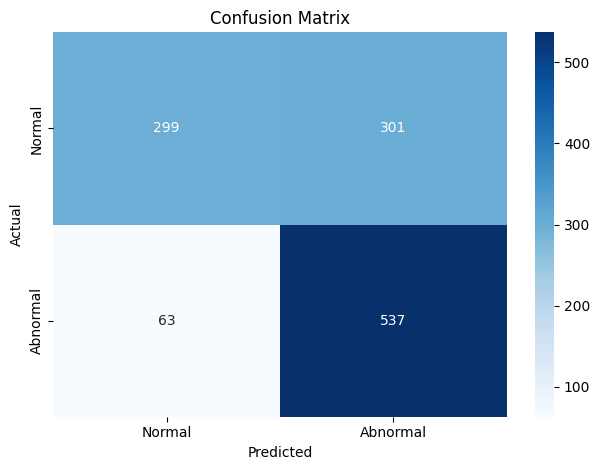

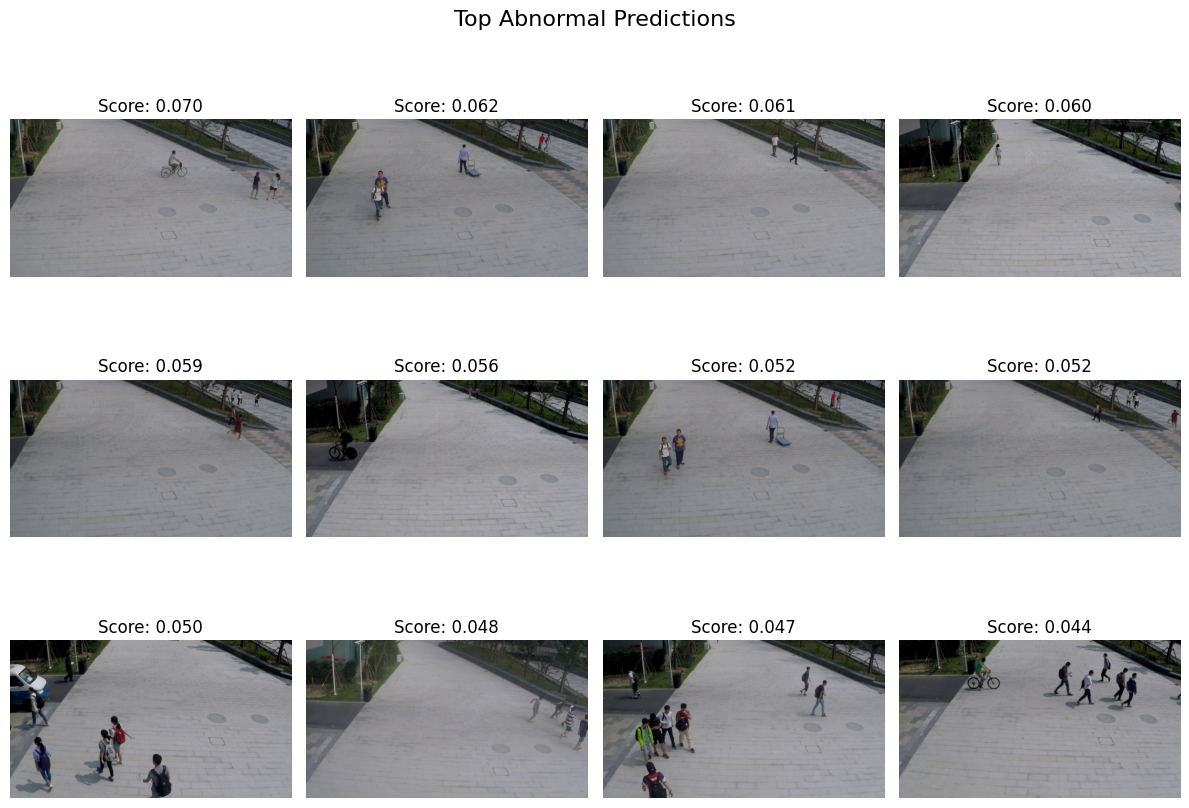

In [ ]:
from glob import glob

# Rebuild test image paths
test_image_paths = sorted(glob("/content/drive/MyDrive/shanghai_dataset/test/*/*.jpg"))

## Run all visualizations
plot_roc_curve(best_ensemble_scores, test_labels)
plot_precision_recall_curve(best_ensemble_scores, test_labels)
plot_score_distributions(all_scores, test_labels)
plot_auc_weight_bar_chart(all_scores, test_labels, list(best_weights))
plot_confusion_matrix(test_labels, final_results['predictions'])
show_prototype_gallery(best_ensemble_scores, test_image_paths)


# PaDim Anomaly Detector

## Import dependencies

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import time
import random
from sklearn.covariance import LedoitWolf
import torchvision.models as models
import os
import gc
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from scipy import stats
from sklearn.random_projection import SparseRandomProjection
from scipy.stats import multivariate_normal
from scipy.signal import savgol_filter
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from scipy.ndimage import gaussian_filter
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch.nn.functional as F
from scipy.stats import rankdata
from torchvision.models import resnet18, mobilenet_v2
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Frame Dataset definition

In [ ]:
class TrainFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=None, seed=42):
        self.root_dir = Path(root_dir)
        self.transform = transform

        # Get all jpg images
        all_images = sorted(list(self.root_dir.glob("*.jpg")))

        if len(all_images) == 0:
            raise FileNotFoundError(f"No .jpg images found in {self.root_dir}")

        # Randomly sample images
        if max_samples and max_samples < len(all_images):
            random.seed(seed)
            self.image_paths = random.sample(all_images, max_samples)
        else:
            self.image_paths = all_images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
class FrameDataset(Dataset):
    def __init__(self, root_dir, transform=None, return_path=False, max_samples=None):
        self.transform = transform
        self.return_path = return_path
        self.data = []

        root_dir = Path(root_dir)

        for label_dir in ['normal', 'abnormal']:
            full_dir = root_dir / label_dir
            label = 0 if label_dir == 'normal' else 1

            if not full_dir.exists():
                raise FileNotFoundError(f"Missing folder: {full_dir}")

            jpg_files = list(full_dir.glob("*.jpg"))
            png_files = list(full_dir.glob("*.png"))
            all_files = sorted(jpg_files + png_files)

            if max_samples:
                step = max(1, len(all_files) // max_samples)
                all_files = all_files[::step][:max_samples]

            for f in all_files:
                self.data.append((f, label))

        if len(self.data) == 0:
            raise ValueError("No images found in normal or abnormal folders.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        try:
            image = Image.open(path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            image = torch.zeros(3, 224, 224)

        return (image, label, str(path)) if self.return_path else (image, label)

## Padim anomaly detector

In [ ]:
class LightweightPaDiM(nn.Module):
    """
    Lightweight PaDiM (Patch Distribution Modeling) anomaly detection model.

    Args:
        backbone_name (str): Backbone CNN (default: 'resnet18').
        num_selected_features (int): Number of top-variance features to keep.
        device (torch.device, optional): Device to run computations on.
    """
    def __init__(self, backbone_name='resnet18', num_selected_features=100, device=None):
        super().__init__()
        self.num_selected_features = num_selected_features
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Build backbone
        self._build_backbone(backbone_name)

        # Learned parameters
        self.mean = None
        self.cov_inv = None
        self.selected_dims = None
        self.feature_mean = None
        self.feature_std = None
        self.spatial_dims = None


    # Backbone

    def _build_backbone(self, backbone_name):
        """Initializes and freezes the CNN backbone."""
        if backbone_name != 'resnet18':
            raise ValueError(f"Unsupported backbone: {backbone_name}")

        model = models.resnet18(pretrained=True)
        layers = list(model.children())

        self.stem = nn.Sequential(*layers[:4])
        self.layer1 = layers[4]
        self.layer2 = layers[5]
        self.layer3 = layers[6]
        self.layer4 = layers[7]

        for param in self.parameters():
            param.requires_grad = False

    def to(self, device):
        """Moves model and stored parameters to the specified device."""
        self.device = device
        super().to(device)
        for attr in ['mean', 'cov_inv', 'selected_dims', 'feature_mean', 'feature_std']:
            val = getattr(self, attr)
            if val is not None and torch.is_tensor(val):
                setattr(self, attr, val.to(device))
        return self


    # Feature Extraction

    def _extract_features(self, x):
        """Extracts multi-scale features from the backbone."""
        with torch.no_grad():
            x = self.stem(x)
            x1 = self.layer1(x)
            x2 = self.layer2(x1)
            x3 = self.layer3(x2)
            x4 = self.layer4(x3)

            target_size = (14, 14)
            f2 = F.adaptive_avg_pool2d(x2, target_size)
            f3 = F.adaptive_avg_pool2d(x3, target_size)
            f4 = F.adaptive_avg_pool2d(x4, target_size)

            combined = torch.cat([f2, f3, f4], dim=1)  # (B, C, H, W)
            B, C, H, W = combined.shape
            self.spatial_dims = (H, W)

            return combined.permute(0, 2, 3, 1).reshape(B, H * W, C)


    # Training (Fitting)

    def fit(self, dataloader, device=None):
        """Fits the model using only normal images."""
        device = device or self.device
        self.to(device)
        self.eval()

        all_features = []
        for x in tqdm(dataloader, desc="Fitting PaDiM"):
            x = x.to(device)
            feats = self._extract_features(x)
            all_features.append(feats.cpu().numpy())

        all_features = np.concatenate(all_features, axis=0)  # (N, spatial_dim, C)
        N, spatial_dim, C = all_features.shape

        # Compute normalization stats
        features_flat = all_features.reshape(-1, C)
        self.feature_mean = torch.tensor(features_flat.mean(axis=0), dtype=torch.float32, device=device)
        self.feature_std = torch.tensor(features_flat.std(axis=0) + 1e-8, dtype=torch.float32, device=device)

        # Feature selection by variance
        norm_features = (features_flat - self.feature_mean.cpu().numpy()) / self.feature_std.cpu().numpy()
        feature_vars = np.var(norm_features, axis=0)
        top_idx = np.argsort(feature_vars)[-self.num_selected_features:]
        self.selected_dims = torch.tensor(top_idx, dtype=torch.long, device=device)

        # Fit Gaussian parameters
        selected_features = norm_features[:, top_idx]
        mean = selected_features.mean(axis=0)
        cov = np.cov(selected_features, rowvar=False) + 1e-6 * np.eye(len(top_idx))
        cov_inv = np.linalg.pinv(cov)

        self.mean = torch.tensor(mean, dtype=torch.float32, device=device)
        self.cov_inv = torch.tensor(cov_inv, dtype=torch.float32, device=device)

        print(f" Training complete. Features used: {len(top_idx)}")


    # Prediction

    def predict(self, dataloader, device=None):
        """Predicts anomaly scores for test images."""
        device = device or self.device
        self.to(device)
        self.eval()

        scores, labels = [], []
        with torch.no_grad():
            for x, y in tqdm(dataloader, desc="Predicting"):
                x = x.to(device)
                feats = self._extract_features(x)
                feats = (feats - self.feature_mean) / self.feature_std
                feats = feats[:, :, self.selected_dims]

                for b in range(feats.shape[0]):
                    d = feats[b] - self.mean
                    mdist = torch.sum((d @ self.cov_inv) * d, dim=1)
                    scores.append(torch.max(mdist).item())
                    labels.append(y[b].item())

        return np.array(scores), np.array(labels)


    # Heatmap Generation

    def generate_heatmap(self, image_tensor, device=None):
        """
        Generate an anomaly heatmap for a single image.

        Args:
            image_tensor (torch.Tensor): shape (1, 3, 224, 224)
            device (torch.device): computation device

        Returns:
            heatmap_resized (np.ndarray): (224, 224)
            score (float): max anomaly score
        """
        device = device or self.device
        self.eval()
        image_tensor = image_tensor.to(device)

        with torch.no_grad():
            feats = self._extract_features(image_tensor)
            feats = (feats - self.feature_mean) / self.feature_std
            feats = feats[:, :, self.selected_dims]

            d = feats[0] - self.mean
            mdist = torch.sum((d @ self.cov_inv) * d, dim=1)

            heatmap = mdist.view(*self.spatial_dims).cpu().numpy()
            heatmap_resized = cv2.resize(heatmap, (224, 224))
            score = np.max(mdist.cpu().numpy())

        return heatmap_resized, score


    # Save / Load

    def save_state(self, path="light_padim.pth"):
        """Save the model parameters for later use."""
        torch.save({
            "mean": self.mean.cpu(),
            "cov_inv": self.cov_inv.cpu(),
            "selected_dims": self.selected_dims.cpu().long(),
            "feature_mean": self.feature_mean.cpu(),
            "feature_std": self.feature_std.cpu(),
            "spatial_dims": self.spatial_dims,
            "num_selected_features": self.num_selected_features
        }, path)
        print(f" Model saved to {path}")

    def load_state(self, path):
        """Load saved model parameters."""
        state = torch.load(path, map_location=self.device)
        self.mean = state["mean"].to(self.device)
        self.cov_inv = state["cov_inv"].to(self.device)
        self.selected_dims = state["selected_dims"].to(self.device).long()
        self.feature_mean = state["feature_mean"].to(self.device)
        self.feature_std = state["feature_std"].to(self.device)
        self.spatial_dims = state.get("spatial_dims", None)
        self.num_selected_features = state.get("num_selected_features", self.num_selected_features)
        print(f" Model loaded from {path}")


## Pipeline

In [ ]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def run_padim(train_dir, test_normal_dir, test_abnormal_dir,
              batch_size=32, max_train_samples=2000, visualize=True):

    print("Running Lightweight PaDiM")

    transform = get_transforms()

    # Custom dataset should randomly sample internally if needed
    train_set = TrainFrameDataset(train_dir, transform=transform, max_samples=max_train_samples)
    normal_set = FrameDataset(test_normal_dir, transform=transform)
    abnormal_set = FrameDataset(test_abnormal_dir, transform=transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    normal_loader = DataLoader(normal_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    abnormal_loader = DataLoader(abnormal_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LightweightPaDiM(backbone_name='resnet18', num_selected_features=300)

    start = time.time()
    model.fit(train_loader, device)

    normal_scores = model.predict(normal_loader, device)
    abnormal_scores = model.predict(abnormal_loader, device)

    scores = np.concatenate([normal_scores, abnormal_scores])
    labels = np.concatenate([np.zeros(len(normal_scores)), np.ones(len(abnormal_scores))])

   # Ensure labels are binary (0 = normal, 1 = abnormal)
    labels = np.array(labels)
    scores = np.array(scores)

    auc = roc_auc_score(labels, scores)

    print(f"\n ROC-AUC: {auc:.4f}")
    print(f" Total runtime: {(time.time() - start)/60:.1f} min")

    if visualize:
        plot_roc_curve(scores, labels)
        plot_score_kde(scores, labels)

    return scores, labels, auc, model


def plot_roc_curve(scores, labels):
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(labels, scores)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve", color="blue")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_score_kde(scores, labels):
    sns.kdeplot(scores[labels == 0], label='Normal', fill=True)
    sns.kdeplot(scores[labels == 1], label='Anomalous', fill=True)
    plt.title("Score Distribution")
    plt.xlabel("Anomaly Score")
    plt.legend()
    plt.grid(True)
    plt.show()



## Run

In [ ]:
train_dir = "/content/drive/MyDrive/shanghai_dataset/split/train"
test_normal_dir = "/content/drive/MyDrive/shanghai_dataset/test/normal"
test_abnormal_dir = "/content/drive/MyDrive/shanghai_dataset/test/abnormal"

scores, labels, auc, model = run_padim(
    train_dir,
    test_normal_dir,
    test_abnormal_dir,
    batch_size=16,
    max_train_samples=2000
)

# Save model
model.save_state("light_padim_resnet18.pth")



 Running Lightweight PaDiM


In [ ]:
def plot_roc_curve(scores, labels, title="PaDiM ROC Curve"):
    fpr, tpr, _ = roc_curve(labels, scores)
    auc = roc_auc_score(labels, scores)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_score_kde(scores, labels, title="PaDiM Score Distribution"):
    plt.figure(figsize=(7, 4))
    sns.kdeplot(scores[labels == 0], label='Normal', linestyle='--')
    sns.kdeplot(scores[labels == 1], label='Abnormal')
    plt.title(title)
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Visualize

In [ ]:

# Instantiate the model
model2 = LightweightPaDiM(backbone_name='resnet18', num_selected_features=300)

# Set device
device = 'cuda'
model2.to(device)

# Load the saved state
model2.load_state("/content/drive/MyDrive/shanghai_dataset/light_padim_resnet18.pth")

# Also move backbone if it's cached in the model (recommended)
if hasattr(model2, 'backbone'):
    model2.backbone.to(device)
    model2.backbone.eval()

transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


test_dir = "/content/drive/MyDrive/shanghai_dataset/test"
test_dataset = FrameDataset(test_dir, transform=transform, max_samples=1500)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


 Model loaded from /content/drive/MyDrive/shanghai_dataset/light_padim_resnet18.pth


Predicting: 100%|██████████| 500/500 [01:33<00:00,  5.32it/s]


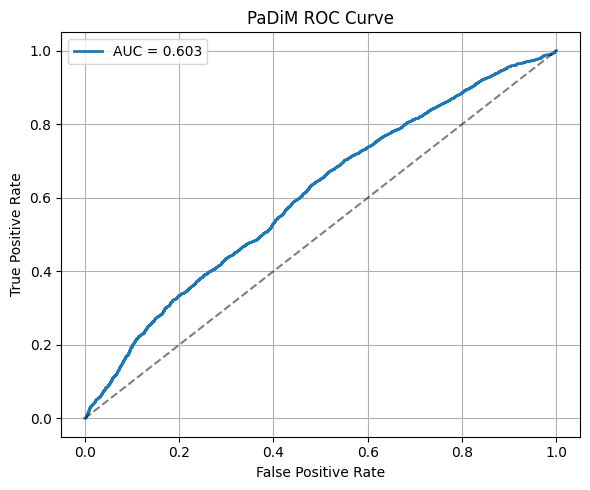

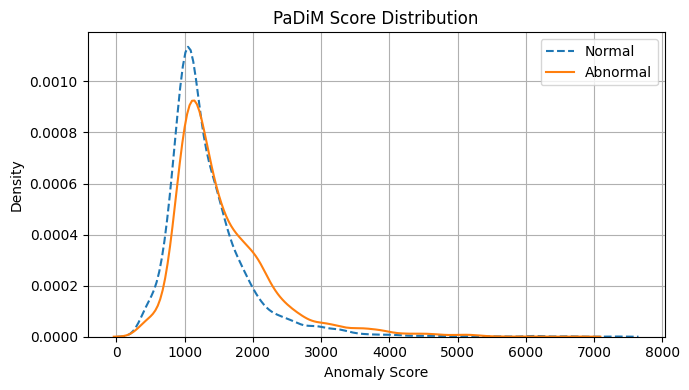

In [ ]:
scores, labels = model2.predict(test_loader, device='cuda')
# Visualize
plot_roc_curve(scores, labels)
plot_score_kde(scores, labels)
np.save("padim_scores.npy", scores)
np.save("labels.npy", labels)

### HEAT MAPS

In [ ]:
model3 = LightweightPaDiM(num_selected_features=100)
model3.load_state("/content/drive/MyDrive/shanghai_dataset/light_padim_resnet18.pth")
model3.to('cuda')

def visualize_padim_heatmap(image_tensor, heatmap, score=None, label=None, figsize=(7, 3)):
    """
    Displays the original image and overlayed heatmap side by side.

    Args:
        image_tensor (torch.Tensor): shape (1, 3, H, W)
        heatmap (np.ndarray): shape (H, W)
        score (float, optional): anomaly score to annotate.
        label (int, optional): ground truth label (0=normal, 1=anomaly).
        figsize (tuple): figure size.
    """
    # Convert image tensor to NumPy [0, 1]
    img = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    # Plot
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    title = "Anomaly Heatmap"
    if score is not None:
        title += f"\nScore: {score:.3f}"
    if label is not None:
        title += f" | Label: {'Abnormal' if label else 'Normal'}"
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()



 Model loaded from /content/drive/MyDrive/shanghai_dataset/light_padim_resnet18.pth


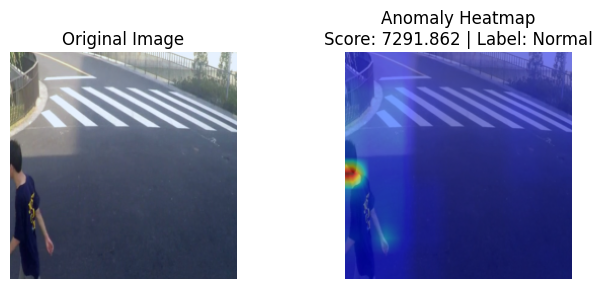

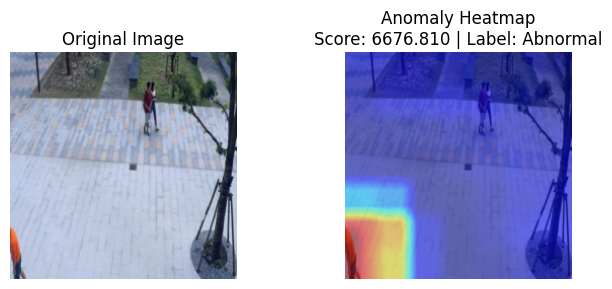

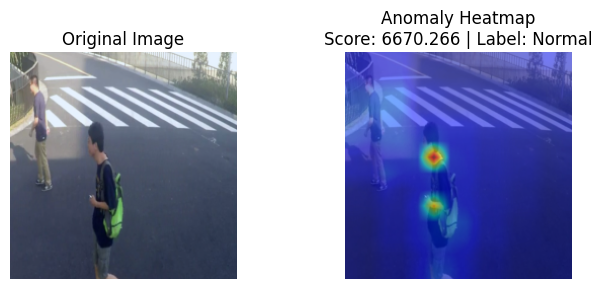

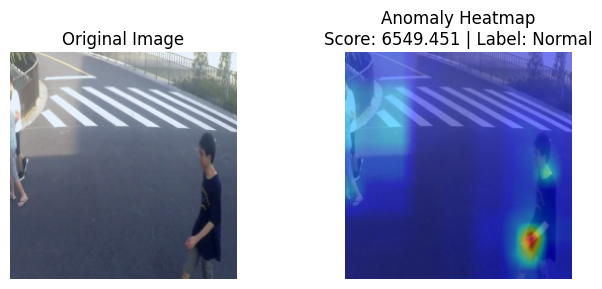

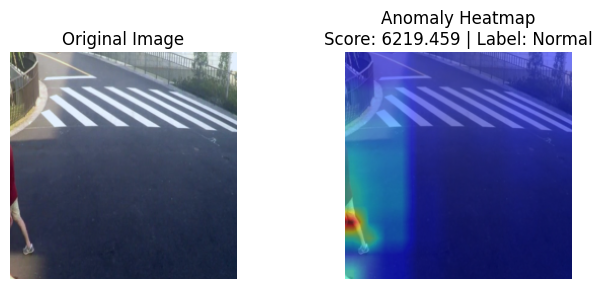

In [ ]:
## Get top 5 high-score indices

topk = 5
top_indices = np.argsort(scores)[-topk:][::-1]

for idx in top_indices:
    img_tensor, label = test_dataset[idx]
    img_tensor = img_tensor.unsqueeze(0)  # make batch shape
    heatmap, score = model3.generate_heatmap(img_tensor)
    visualize_padim_heatmap(img_tensor, heatmap, score=score, label=label)


# SPADE

## Import libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm
from scipy.spatial.distance import cosine
import cv2
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans
from torchvision import models
import torch.nn.functional as F
import seaborn as sns
from scipy.ndimage import uniform_filter1d


### Set device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set Up Grad-CAM Backbone

In [ ]:
class MultiLayerGradCAMResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.target_layers = ['layer2', 'layer3', 'layer4']
        self.gradients = {}
        self.activations = {}
        self._register_hooks()

    def _register_hooks(self):
        for name in self.target_layers:
            layer = dict(self.model.named_modules())[name]
            layer.register_forward_hook(self._save_activations(name))
            layer.register_backward_hook(self._save_gradients(name))

    def _save_activations(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    def _save_gradients(self, name):
        def hook(module, grad_in, grad_out):
            self.gradients[name] = grad_out[0]
        return hook

    def forward(self, x):
        return self.model(x)

    def generate_fused_cam(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.forward(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        cams = []
        for name in self.target_layers:
            grad = self.gradients[name]
            act = self.activations[name]
            weights = torch.mean(grad, dim=(2, 3), keepdim=True)
            cam = torch.sum(weights * act, dim=1)
            cam = F.relu(cam)
            cam_min = cam.view(cam.size(0), -1).min(1, keepdim=True)[0].view(-1, 1, 1)
            cam_max = cam.view(cam.size(0), -1).max(1, keepdim=True)[0].view(-1, 1, 1)
            cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
            cam = F.interpolate(cam.unsqueeze(1), size=(224, 224), mode='bilinear', align_corners=False).squeeze(1)
            cams.append(cam)

        fused_cam = torch.stack(cams).mean(0)
        return fused_cam.squeeze(0).detach().cpu().numpy()


## Load Dataset

In [ ]:
class FrameDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=1200):
        self.transform = transform
        self.samples = []
        for label_str, label in [("normal", 0), ("abnormal", 1)]:
            for path in sorted(Path(root_dir, label_str).glob("*.jpg")):
                self.samples.append((path, label))

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.samples)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = FrameDataset("/content/drive/MyDrive/shanghai_dataset/test", transform,max_samples=1200)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


## CAM SMOOTHING + SSIM

In [ ]:
def smooth_cam(cam, sigma=4):
    return cv2.GaussianBlur(cam, (0, 0), sigmaX=sigma, sigmaY=sigma)

def spade_score_ssim(cam, ref_cam):
    sim, _ = ssim(cam, ref_cam, full=True, data_range=1.0)
    return 1 - sim


## Compute SPADE Anomaly Scores

In [ ]:
def compute_reference_cam(model, dataloader, device='cuda', max_samples=100):
    model.to(device).eval()
    cams = []

    for img, label in dataloader:
        if label.item() == 0:  # normal
            img = img.to(device)
            _ = model(img)
            cam = model.generate_fused_cam(img)
            cam = smooth_cam(cam)  # smooth
            cams.append(cam)
            if len(cams) >= max_samples:
                break

    return np.mean(np.stack(cams), axis=0)

def compute_spade_scores(model, dataloader, ref_cam, device='cuda'):
    model.to(device).eval()
    scores = []
    labels = []

    for img, label in tqdm(dataloader, desc="Running SPADE"):
        img = img.to(device)
        _ = model(img)
        cam = model.generate_fused_cam(img)
        cam = smooth_cam(cam)
        score = spade_score_ssim(cam, ref_cam)
        scores.append(score)
        labels.append(label.item())

    return np.array(scores), np.array(labels)

## Visualize SPADE Heatmap

In [ ]:
def plot_score_distribution(scores, labels):
    plt.figure(figsize=(8, 4))
    sns.kdeplot(scores[labels == 0], label="Normal", linestyle='--')
    sns.kdeplot(scores[labels == 1], label="Anomaly")
    plt.title("SPADE Score Distribution (SSIM-based)")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def show_spade_heatmap(img_tensor, cam, label=None, score=None):
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    cam = cv2.resize(cam, (224, 224))

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    title = "SPADE Heatmap"
    if score is not None:
        title += f"\nScore: {score:.3f}"
    if label is not None:
        title += f" | Label: {'Anomaly' if label else 'Normal'}"
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## Run

Running SPADE: 100%|██████████| 8000/8000 [03:25<00:00, 38.90it/s]


SPADE AUC (SSIM + Smoothed + Fused): 0.5093


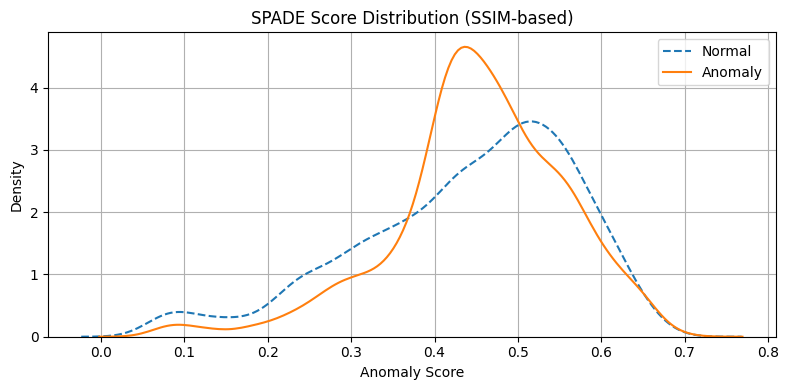

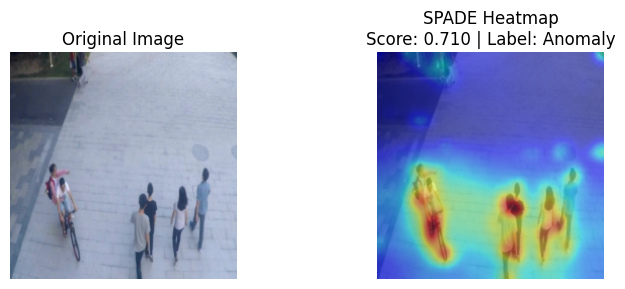

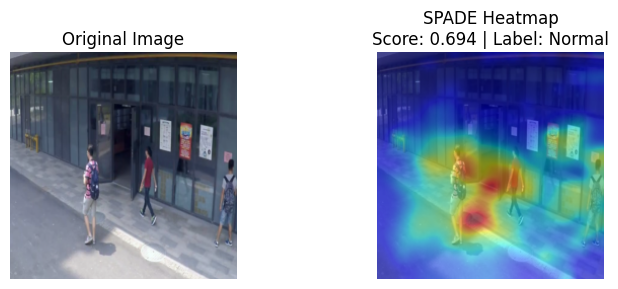

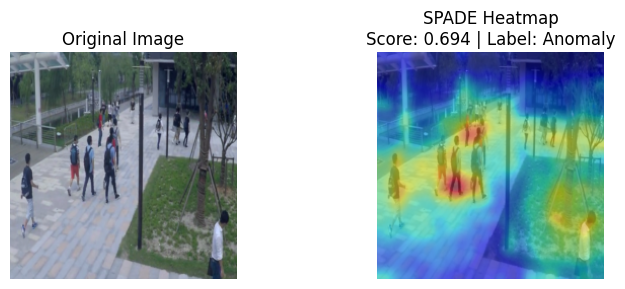

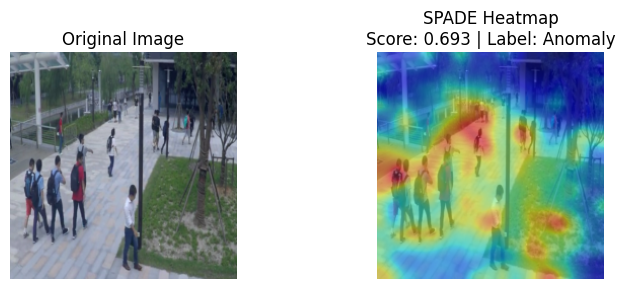

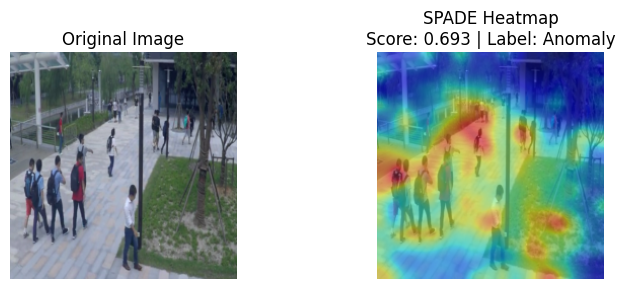

In [ ]:
spade_model = MultiLayerGradCAMResNet18()

# Compute reference CAM
reference_cam = compute_reference_cam(spade_model, test_loader, device='cuda', max_samples=100)

# Run scoring
spade_scores, spade_labels = compute_spade_scores(spade_model, test_loader, reference_cam, device='cuda')

# Evaluate
auc_spade = roc_auc_score(spade_labels, spade_scores)
print(f"SPADE AUC (SSIM + Smoothed + Fused): {auc_spade:.4f}")

# Plot distributions
plot_score_distribution(spade_scores, spade_labels)

# Visualize top 5
top_idxs = np.argsort(spade_scores)[-5:][::-1]
for idx in top_idxs:
    img_tensor, label = test_dataset[idx]
    img_tensor = img_tensor.unsqueeze(0).to('cuda')
    _ = spade_model(img_tensor)
    cam = spade_model.generate_fused_cam(img_tensor)
    cam = smooth_cam(cam)
    show_spade_heatmap(img_tensor.cpu(), cam, label=label, score=spade_scores[idx])


In [ ]:
np.save("spade_scores.npy", spade_scores)

# Ensemble Fusion

## Import libraries

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import itertools
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score

## Normalize Scores

### Load the scores

In [ ]:
padim_scores = np.load("padim_scores.npy")
spade_scores = np.load("spade_scores.npy")
labels = np.load("clip_test_labels.npy")


clip_max = np.load("clip_max_similarity.npy")
clip_mean = np.load("clip_mean_similarity.npy")
clip_dist = np.load("clip_distance_based.npy")


clip_scores = np.load("clip_fused_score.npy")

clip_scores = clip_scores[:1200]
padim_scores = padim_scores[:1200]
spade_scores = spade_scores[:1200]



best_weights={'mean_similarity': 0.571, 'topk_similarity': 0.286, 'distance_based': 0.143}

np.save("best_weights.npy", best_weights)
loaded_weights = np.load('best_weights.npy', allow_pickle=True).item()


{'mean_similarity': 0.571, 'topk_similarity': 0.286, 'distance_based': 0.143}


In [ ]:
print("Labels unique:", np.unique(labels, return_counts=True))


Labels unique: (array([0, 1]), array([600, 600]))


In [ ]:
def normalize_scores(scores_dict):
    scaler = MinMaxScaler()
    normalized = {}
    for name, scores in scores_dict.items():
        scores = np.array(scores).reshape(-1, 1)
        normalized[name] = scaler.fit_transform(scores).flatten()
    return normalized

all_scores = {
    "CLIP": clip_scores,
    "PaDiM": padim_scores,
    "SPADE": spade_scores
}

norm_scores = normalize_scores(all_scores)


In [ ]:
for name, scores in norm_scores.items():
    print(f"AUC for {name}: {roc_auc_score(labels, scores):.4f}")


AUC for CLIP: 0.7830
AUC for PaDiM: 0.5147
AUC for SPADE: 0.5039


## Weighted Average Fusion + AUC Search

In [ ]:
def find_best_fusion(norm_scores, labels, steps=10):
    methods = list(norm_scores.keys())
    weights_list = list(itertools.product(
        *(np.linspace(0, 1, steps) for _ in methods)
    ))
    weights_list = [w for w in weights_list if abs(sum(w) - 1.0) < 1e-2]

    best_auc = 0
    best_weights = None
    best_fused = None

    for weights in weights_list:
        fused = sum(w * norm_scores[m] for w, m in zip(weights, methods))
        auc = roc_auc_score(labels, fused)
        if auc > best_auc:
            best_auc = auc
            best_weights = weights
            best_fused = fused

    # Fallback if no improvement found
    if best_weights is None:
        best_weights = [1 / len(methods)] * len(methods)
        best_fused = np.mean([norm_scores[m] for m in methods], axis=0)

    return best_auc, best_weights, best_fused


## Bar Chart of AUC vs Weight

In [ ]:
def plot_auc_vs_weight(norm_scores, labels, best_weights):
    aucs = [roc_auc_score(labels, norm_scores[m]) for m in norm_scores]
    x = np.arange(len(norm_scores))

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.bar(x - 0.2, aucs, width=0.4, color='skyblue', label='AUC')
    ax1.set_ylabel("AUC", color='blue')
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.bar(x + 0.2, best_weights, width=0.4, color='orange', label='Weight')
    ax2.set_ylabel("Weight", color='orange')
    ax2.set_ylim(0, 1)

    plt.xticks(x, list(norm_scores.keys()), rotation=45)
    plt.title("Individual AUC vs Ensemble Weights")
    fig.tight_layout()
    plt.show()


##  Run the Ensemble Fusion

Best Ensemble AUC: 0.783
Best Weights: {'CLIP': np.float64(1.0), 'PaDiM': np.float64(0.0), 'SPADE': np.float64(0.0)}


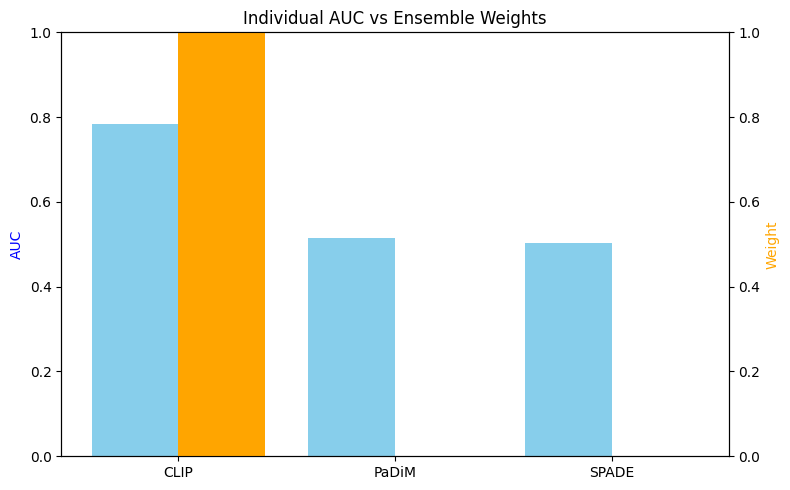

In [ ]:
# Run Fusion
best_auc, best_weights, fused_scores = find_best_fusion(norm_scores, labels, steps=10)

# Report and Plot
print("Best Ensemble AUC:", round(best_auc, 4))
print("Best Weights:", dict(zip(norm_scores.keys(), best_weights)))
plot_auc_vs_weight(norm_scores, labels, best_weights)